## 1. Load EBSD data

In [1]:
%matplotlib inline

# from diffpy.structure import Atom, Lattice, Structure
import matplotlib.pyplot as plt
import numpy as np

from orix import io, plot
from orix.crystal_map import Phase
# from orix.sampling import sample_S2
from orix.vector import Miller, Vector3d
# from orix.crystal_map import CrystalMap, Phase, PhaseList
# from orix.quaternion import Orientation, Rotation, symmetry
from orix.vector import Vector3d
import kikuchipy as kp
import os
from tqdm import tqdm
from visualize_grid import read_data, set_ROI, set_component
from data_processing import get_components, get_eds_average, coord_xmap_dict
from cNMF import run_cNMF, run_cNMF_mixeds, _plot_cnmf, normalize_sum
from PCA import run_PCA, _plot_pca
from matplotlib.colors import TwoSlopeNorm, LinearSegmentedColormap

plt.rcParams.update({"figure.figsize": (7, 7), "font.size": 15})
w, h = plt.rcParams["figure.figsize"]
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
# data_path = "EBSD_scan"
# data_save = "save_map/"

data_path = "../EBSD_scan"

In [3]:
fname_ang = data_path + "/Scan3_cropped.ang"
xmap = io.load(fname_ang)                                                                               

c:\Users\Angelamer\anaconda3\envs\kikuchi_cnmf\Lib\site-packages\orix\io\plugins\ang.py:285: UserWarning: Number of columns, 20, in the file is not equal to the expected number of columns, [14, 10], for the 
assumed vendor 'tsl'. Will therefore assume the following columns: euler1, euler2, euler3, x, y, unknown1, unknown2, phase_id, unknown3, unknown4, etc.
  warnings.warn(


In [4]:
xmap
# eu1, eu2, eu3, x, y, iq, ci, phase_id, sem, Fit, bs, cs, ts, Oxygen, Mg, Al, Si, Ti, Mn, Fe  = np.loadtxt(fname_ang, unpack=True)

Phase   Orientations   Name  Space group  Point group  Proper point group       Color
    1       1 (0.0%)  Fe3O4         None          432                 432   tab:green
    2   1595 (62.7%)    FeO         None          432                 432  tab:orange
    3    946 (37.2%)     Fe         None          432                 432    tab:blue
Properties: unknown1, unknown2, unknown3, unknown4, unknown5, unknown6, unknown7, unknown8, unknown9, unknown10, unknown11, unknown12, unknown13, unknown14
Scan unit: um

In [5]:
edax_binary_path = data_path + "/Scan3_cropped.up1"

s_edax = kp.load(edax_binary_path)
s_edax

<EBSD, title: Scan3_cropped, dimensions: (62, 41|239, 239)>

### 1.1 Phase map/ IQ/ IPF/ CI MAP

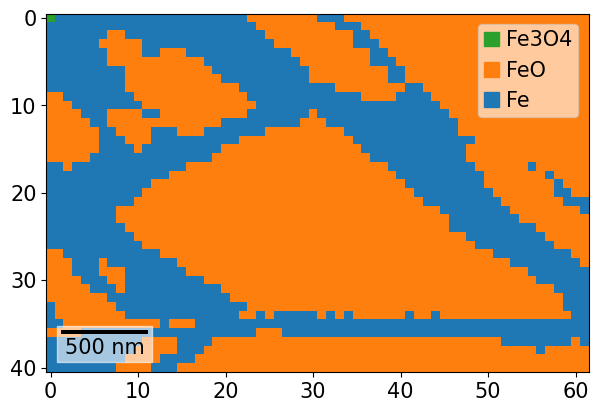

In [9]:
# phase map
xmap.plot()

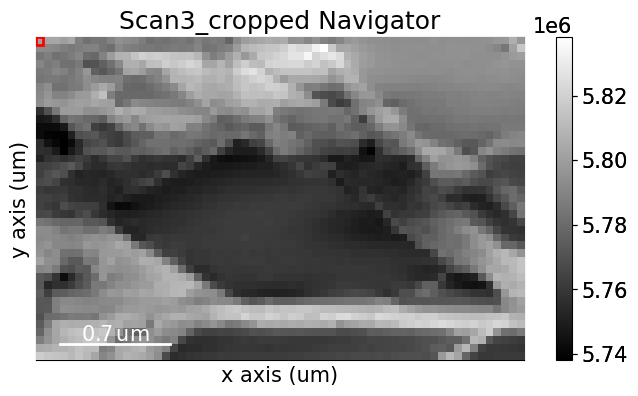

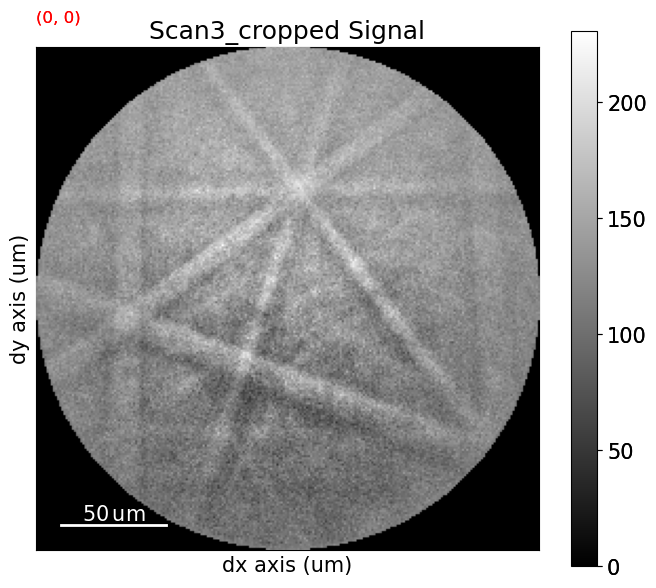

In [10]:
# Image quality map and kikuchi pattern

s_edax.plot()

In [6]:
xmap.phases

Id   Name  Space group  Point group  Proper point group       Color
 1  Fe3O4         None          432                 432   tab:green
 2    FeO         None          432                 432  tab:orange
 3     Fe         None          432                 432    tab:blue

In [6]:
# set the space group number
# the crystal structure of iron would be changed based on the temperature and pressure
# α-Fe (Ferrite): Body-Centered Cubic (BCC)  Im-3m  (229); γ-Fe (Austenite): Face-Centered Cubic (FCC)  Fm-3m(225); δ-Fe; ε-Fe
xmap.phases[1].space_group = 227
xmap.phases[2].space_group = 225
xmap.phases[3].space_group = 229
xmap.phases

Id   Name  Space group  Point group  Proper point group       Color
 1  Fe3O4        Fd-3m         m-3m                 432   tab:green
 2    FeO        Fm-3m         m-3m                 432  tab:orange
 3     Fe        Im-3m         m-3m                 432    tab:blue

In [8]:
# rotations and orientation quaternions of different phases with respect of reference 
r = xmap.rotations

magnetite_ori = xmap["Fe3O4"].orientations
wustite_ori = xmap["FeO"].orientations
iron_ori = xmap["Fe"].orientations

Miller (12,), point group m-3m, hkil
[[ 0.  1. -1.  1.]
 [-1.  0.  1.  1.]
 [ 0. -1.  1.  1.]
 [ 1.  0. -1.  1.]
 [ 0. -1.  1. -1.]
 [ 1.  0. -1. -1.]
 [ 0.  1. -1. -1.]
 [-1.  0.  1. -1.]
 [ 1. -1. -0.  0.]
 [ 1.  1. -2.  0.]
 [-1.  1. -0.  0.]
 [-1. -1.  2.  0.]]
[########################################] | 100% Completed | 215.32 ms


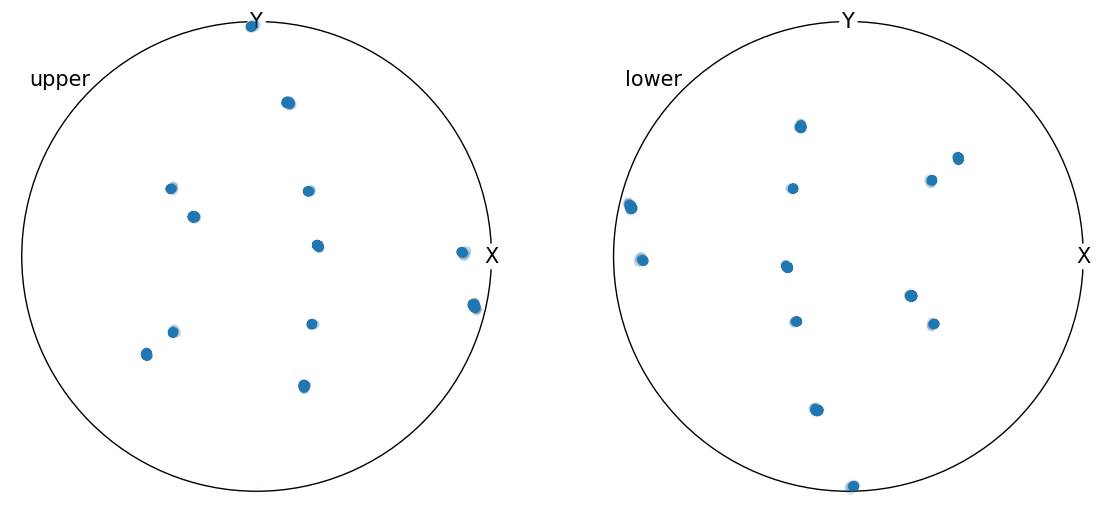

In [9]:
# define the crystal's point group and generate the set of symmetrically unique (011_1) 
g_wu = Miller(hkil=(0, 1, -1, 1), phase=Phase(point_group=wustite_ori.symmetry))
g_wu = g_wu.symmetrise(unique=True)
print(g_wu)
# compute the direction of poles in the sample reference frame
poles = wustite_ori.inv().outer(g_wu, lazy=True, progressbar=True, chunk_size=2000)

# plot the poles in the stereographic projection
poles.scatter(
    hemisphere="both",
    alpha=0.02,
    figure_kwargs={"figsize": (2 * h, h)},
    axes_labels=["X", "Y"],
)

Miller (12,), point group m-3m, hkil
[[ 0.  1. -1.  1.]
 [-1.  0.  1.  1.]
 [ 0. -1.  1.  1.]
 [ 1.  0. -1.  1.]
 [ 0. -1.  1. -1.]
 [ 1.  0. -1. -1.]
 [ 0.  1. -1. -1.]
 [-1.  0.  1. -1.]
 [ 1. -1. -0.  0.]
 [ 1.  1. -2.  0.]
 [-1.  1. -0.  0.]
 [-1. -1.  2.  0.]]
[########################################] | 100% Completed | 321.45 ms


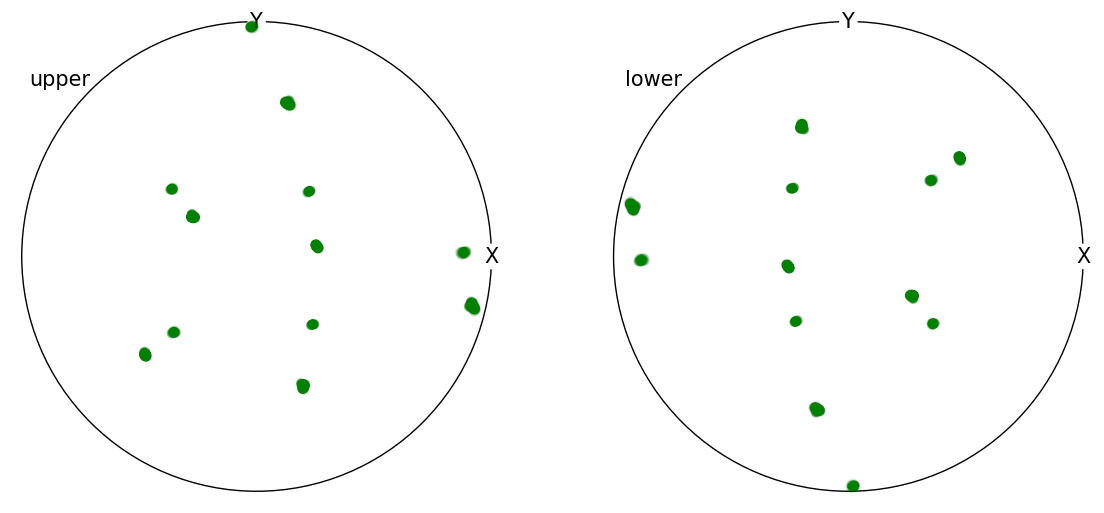

In [11]:
# define the crystal's point group and generate the set of symmetrically unique (011_1) 
g_ir = Miller(hkil=(0, 1, -1, 1), phase=Phase(point_group=iron_ori.symmetry))
g_ir = g_ir.symmetrise(unique=True)
print(g_ir)
# compute the direction of poles in the sample reference frame
poles = iron_ori.inv().outer(g_ir, lazy=True, progressbar=True, chunk_size=2000)

# plot the poles in the stereographic projection
poles.scatter(
    hemisphere="both",
    alpha=0.02,
    color= 'green',
    figure_kwargs={"figsize": (2 * h, h)},
    axes_labels=["X", "Y"],
)

In [10]:
# IPF from color key
ckey_m3m = plot.IPFColorKeyTSL(
    xmap.phases["FeO"].point_group, direction=Vector3d.zvector()
)
rgb_mag = ckey_m3m.orientation2color(xmap["Fe3O4"].orientations)
rgb_wus = ckey_m3m.orientation2color(xmap["FeO"].orientations)
rgb_iron = ckey_m3m.orientation2color(xmap["Fe"].orientations)

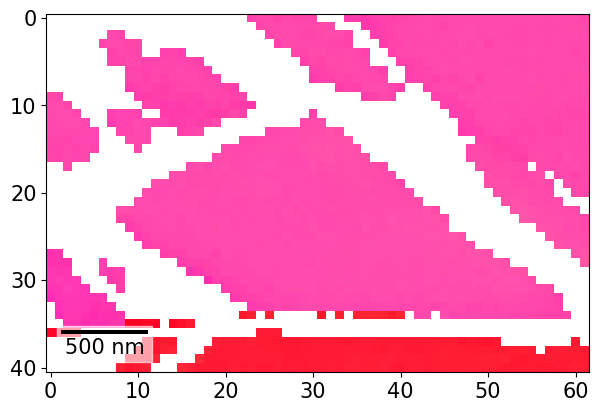

In [11]:
xmap["FeO"].plot(rgb_wus)

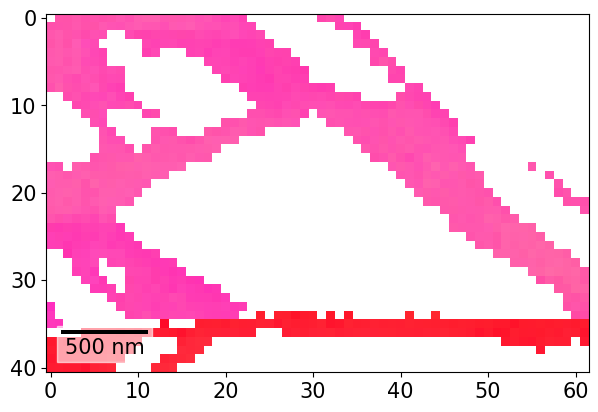

In [12]:
xmap["Fe"].plot(rgb_iron)

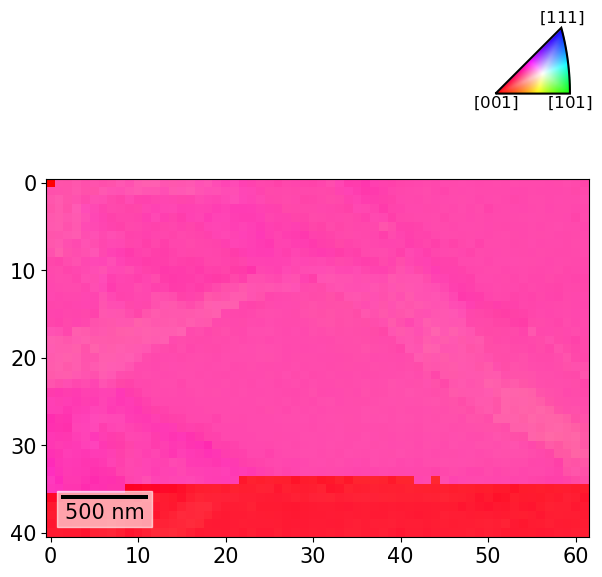

In [13]:
# IPF figure
rgb_all = np.zeros((xmap.size, 3))
rgb_all[xmap.phase_id == 1] = rgb_mag
rgb_all[xmap.phase_id == 2] = rgb_wus
rgb_all[xmap.phase_id == 3] = rgb_iron


fig = xmap.plot(rgb_all, return_figure=True)

rc = {"font.size": 8}
with plt.rc_context(rc):  # Temporarily reduce font size
    ax_ipfkey = fig.add_axes(
        [0.72, 0.87, 0.2, 0.1],
        projection="ipf",
        symmetry=xmap.phases["FeO"].point_group,
    )
    ax_ipfkey.plot_ipf_color_key()
    ax_ipfkey.set_title("")

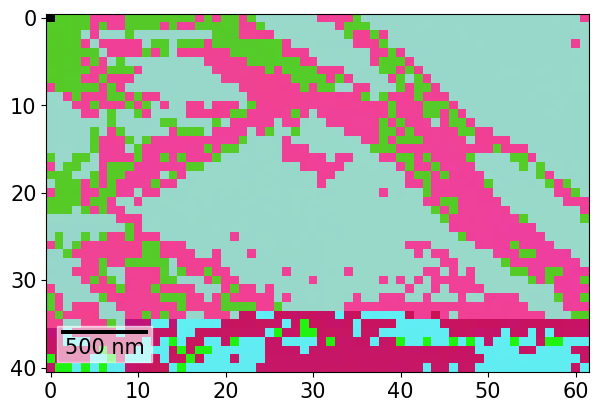

In [14]:
# plot IPF figure from euler angles (φ₁,Φ,φ₂) for rgb values
ckey_euler = plot.EulerColorKey(xmap.phases["FeO"].point_group)
rgb_mag_euler = ckey_euler.orientation2color(xmap["Fe3O4"].orientations)
rgb_wus_euler = ckey_euler.orientation2color(xmap["FeO"].orientations)
rgb_iron_euler = ckey_euler.orientation2color(xmap["Fe"].orientations)


rgb_all_euler = np.zeros((xmap.size, 3))
rgb_all_euler[xmap.phase_id == 1] = rgb_mag_euler
rgb_all_euler[xmap.phase_id == 2] = rgb_wus_euler
rgb_all_euler[xmap.phase_id == 3] = rgb_iron_euler


ipf_euler_fig = xmap.plot(rgb_all_euler,return_figure=True)

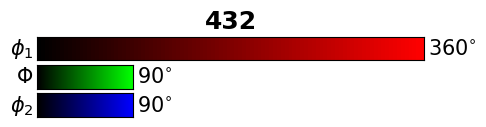

In [15]:
ckey_euler.plot()

In [8]:
# xmap parameters: IQ, CI, sem, fit, bs, cs, ts, oxygen, Mg, Al, Si, Ti, Mn, Fe
xmap.prop


# xmap.prop["iq"] = xmap.prop.pop("unknown1")
# xmap.prop["ci"] = xmap.prop.pop("unknown2")
# xmap.prop["sem"] = xmap.prop.pop("unknown3")
# xmap.prop["fit"] = xmap.prop.pop("unknown4")
# xmap.prop["bs"] = xmap.prop.pop("unknown5")
# xmap.prop["cs"] = xmap.prop.pop("unknown6")
# xmap.prop["ts"] = xmap.prop.pop("unknown7")
# xmap.prop["oxygen"] = xmap.prop.pop("unknown8")
# xmap.prop["Mg"] = xmap.prop.pop("unknown9")
# xmap.prop["Al"] = xmap.prop.pop("unknown10")
# xmap.prop["Si"] = xmap.prop.pop("unknown11")
# xmap.prop["Ti"] = xmap.prop.pop("unknown12")
# xmap.prop["Mn"] = xmap.prop.pop("unknown13")
# xmap.prop["Fe"] = xmap.prop.pop("unknown14")

{'iq': array([0.00000000e+00, 9.64227904e+08, 9.94274304e+08, ...,
        1.26061517e+09, 1.28017229e+09, 1.28190464e+09]),
 'ci': array([0.   , 0.364, 0.241, ..., 0.173, 0.291, 0.291]),
 'sem': array([13840., 13971., 13657., ..., 11867., 12197., 12209.]),
 'fit': array([1.698, 1.872, 1.85 , ..., 1.528, 1.381, 1.4  ]),
 'bs': array([202.768204, 203.100693, 202.624207, ..., 199.769394, 199.568802,
          0.      ]),
 'cs': array([2267.427979, 2271.670898, 2283.7771  , ..., 2210.727051,
        2210.87793 ,    0.      ]),
 'ts': array([319.267609, 319.920807, 320.177887, ..., 299.134186, 299.243195,
          0.      ]),
 'oxygen': array([ 931.,  942., 1004., ..., 1071., 1041., 1022.]),
 'Mg': array([55., 60., 51., ..., 45., 32., 49.]),
 'Al': array([50., 51., 58., ..., 38., 42., 35.]),
 'Si': array([46., 61., 56., ..., 58., 50., 52.]),
 'Ti': array([17., 10., 27., ..., 21., 13., 16.]),
 'Mn': array([19., 12., 14., ..., 18., 24., 15.]),
 'Fe': array([429., 469., 477., ..., 460., 434.

In [7]:
xmap.prop["iq"] = xmap.prop.pop("unknown1")
xmap.prop["ci"] = xmap.prop.pop("unknown2")
xmap.prop["sem"] = xmap.prop.pop("unknown3")
xmap.prop["fit"] = xmap.prop.pop("unknown4")
xmap.prop["bs"] = xmap.prop.pop("unknown5")
xmap.prop["cs"] = xmap.prop.pop("unknown6")
xmap.prop["ts"] = xmap.prop.pop("unknown7")
xmap.prop["oxygen"] = xmap.prop.pop("unknown8")
xmap.prop["Mg"] = xmap.prop.pop("unknown9")
xmap.prop["Al"] = xmap.prop.pop("unknown10")
xmap.prop["Si"] = xmap.prop.pop("unknown11")
xmap.prop["Ti"] = xmap.prop.pop("unknown12")
xmap.prop["Mn"] = xmap.prop.pop("unknown13")
xmap.prop["Fe"] = xmap.prop.pop("unknown14")

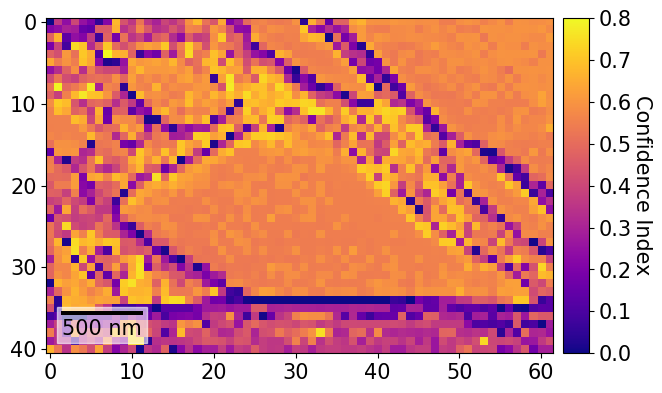

In [93]:
# Confidence index map
fig = xmap.plot(
    xmap.ci,
    cmap="plasma",
    colorbar=True,
    colorbar_label="Confidence Index",
    return_figure=True,
    )

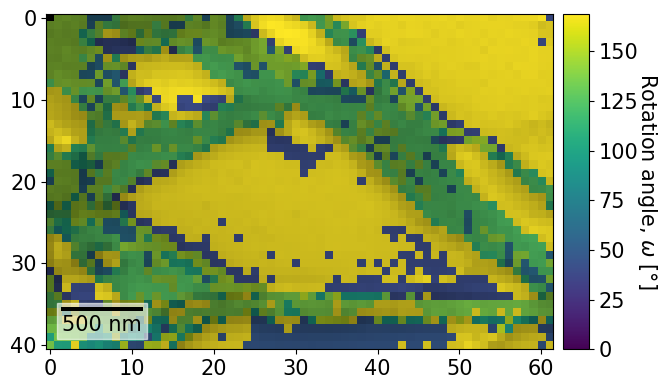

In [94]:
# Get rotation angles in degrees
angles = xmap.rotations.angle * 180 / np.pi

xmap.plot(
    angles,
    vmax=angles.max()-10,
    overlay=xmap.iq,
    colorbar=True,
    colorbar_label=r"Rotation angle, $\omega$ [$\degree$]",
)

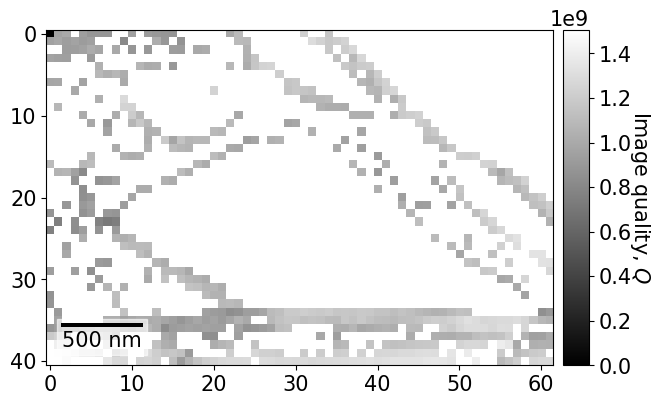

In [31]:
# Conditional slicing：plot the ci value < 0.4 -> boundary
xmap[xmap.ci < 0.4].plot(
    "iq", cmap="gray", colorbar=True, colorbar_label="Image quality, $Q$"
)

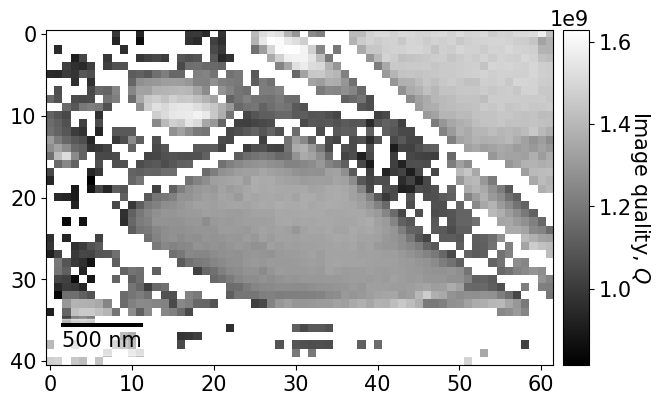

In [ ]:
xmap[xmap.ci > 0.5].plot(
    "iq", cmap="gray", colorbar=True, colorbar_label="Image quality, $Q$"
)

In [11]:
print("The ci value > 0.7, x = ", xmap[xmap.ci > 0.7].x/0.05)
print("The ci value > 0.7, y = ", xmap[xmap.ci > 0.7].y/0.05)

The ci value > 0.7, x =  [31. 21.  3.  7. 14. 17.  4.  7. 17. 22. 26.  1.  5. 22. 28. 39.  4. 22.
 24. 29.  1. 28. 30. 31. 32. 40. 24. 27. 32. 33. 36. 40. 41. 42. 43. 27.
 28. 39. 41. 42. 22. 44. 45. 18. 19. 25. 26. 27. 45. 16. 19. 23. 24. 11.
 16. 42. 38. 41. 13. 15. 39. 55. 40. 41. 51. 56. 41. 47. 58.  2. 45. 46.
 48.  5. 46.  3.  7. 48. 49.  3.  4. 11. 57. 11. 60. 11.  9. 10.  9. 20.
 14. 15. 16. 57. 58. 10. 33. 10. 11. 53.]
The ci value > 0.7, y =  [ 1.  2.  3.  3.  3.  3.  4.  4.  4.  7.  7.  8.  8.  8.  8.  8.  9.  9.
  9.  9. 10. 10. 10. 10. 10. 10. 11. 11. 11. 11. 11. 11. 11. 11. 11. 12.
 12. 12. 12. 12. 13. 13. 13. 14. 14. 14. 14. 14. 14. 15. 15. 15. 15. 16.
 16. 16. 18. 18. 19. 19. 19. 19. 20. 20. 20. 20. 21. 21. 21. 25. 25. 25.
 25. 26. 26. 27. 27. 27. 27. 28. 29. 29. 29. 30. 30. 31. 32. 32. 33. 33.
 34. 34. 34. 34. 34. 38. 38. 39. 39. 39.]


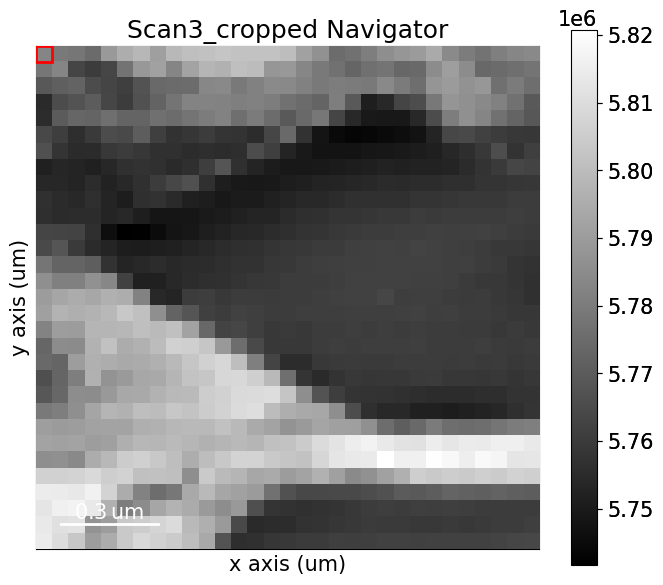

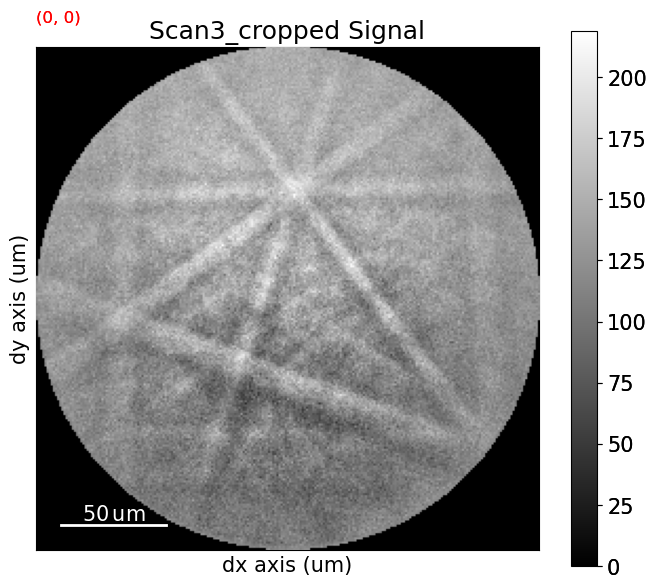

In [12]:
s_edax.inav[5:36,10:41].plot()

In [9]:
s_edax.xmap = xmap
s_edax.xmap.phases

Id   Name  Space group  Point group  Proper point group       Color
 1  Fe3O4        Fd-3m         m-3m                 432   tab:green
 2    FeO        Fm-3m         m-3m                 432  tab:orange
 3     Fe        Im-3m         m-3m                 432    tab:blue

In [90]:
output_dir = "EBSD_scan"
os.makedirs(output_dir, exist_ok=True)  # Create the folder if not existed

# Gain the navigation shape
n_rows, n_cols = s_edax.axes_manager.navigation_shape
print(n_rows, n_cols)
# iterate all the scan points and display the progress
for i in tqdm(range(n_rows)):
    for j in range(n_cols):
        # Obtain the data at [i,j]
        # print(i,j)
        pattern = s_edax.inav[i, j].data

        # Preprocessing normalization?
        # pattern_normalized = (pattern - pattern.min()) / (pattern.max() - pattern.min()) * 255
        # pattern_normalized = pattern_normalized.astype(np.uint8)

        # Define the name of output pictures
        filename = os.path.join(output_dir, f"scan3_x_{i}_y_{j}.jpg")

        # save as jpg(grey figure)
        plt.imsave(filename, pattern, cmap="gray", vmin=pattern.min(), vmax=pattern.max())

62 41


100%|██████████| 62/62 [01:00<00:00,  1.03it/s]


## 1.2 Select initial components

x dimensions 62 
 y dimensions 41 
 in multiples of 1


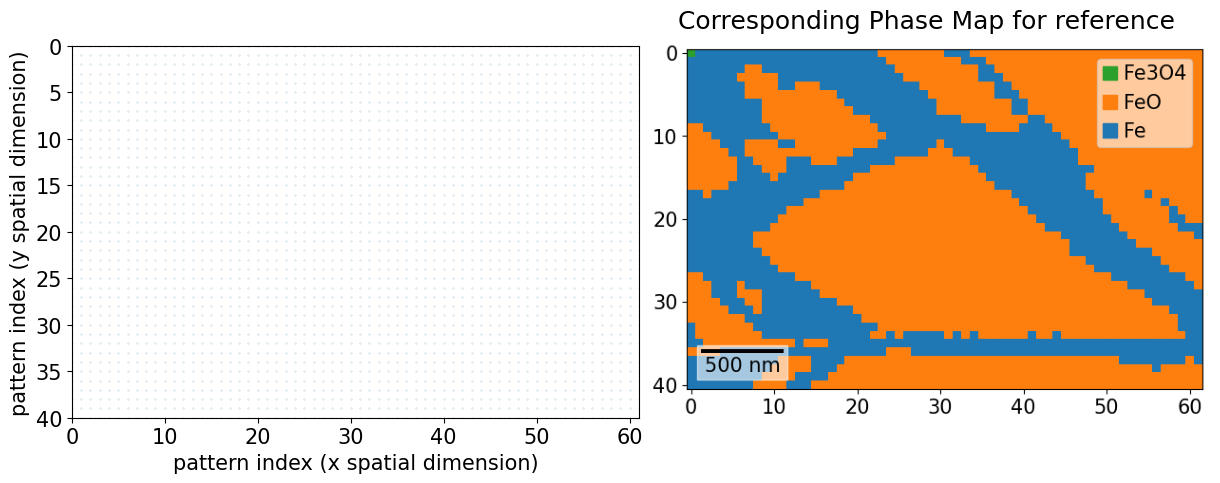

In [10]:
path = "../EBSD_scan/"
grid = read_data(path)

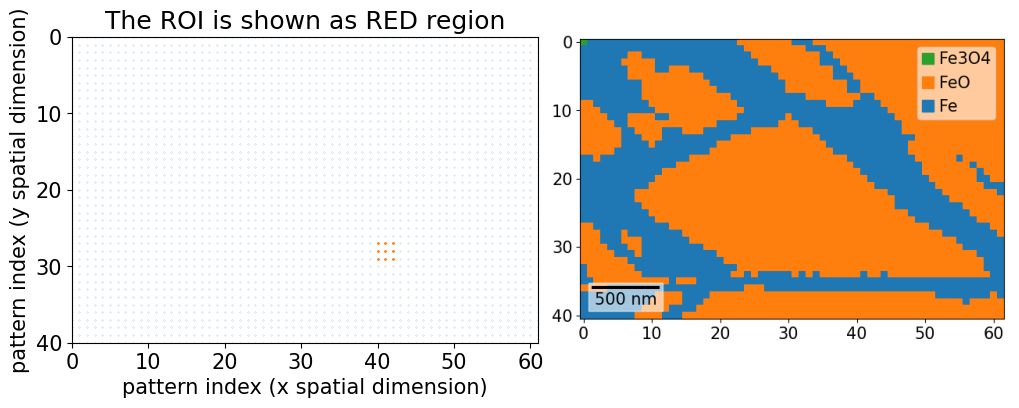

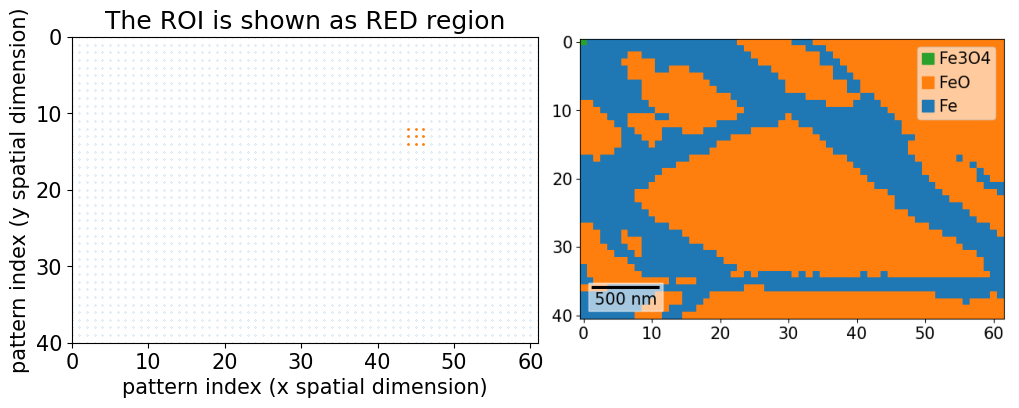

In [11]:
# set components
x_range_1 = (40,42)
y_range_1 = (27,29)
R1 = set_component(x_range_1, y_range_1, path, grid)


x_range_2 = (44,46)
y_range_2 = (12,14)
R2 = set_component(x_range_2, y_range_2, path, grid)


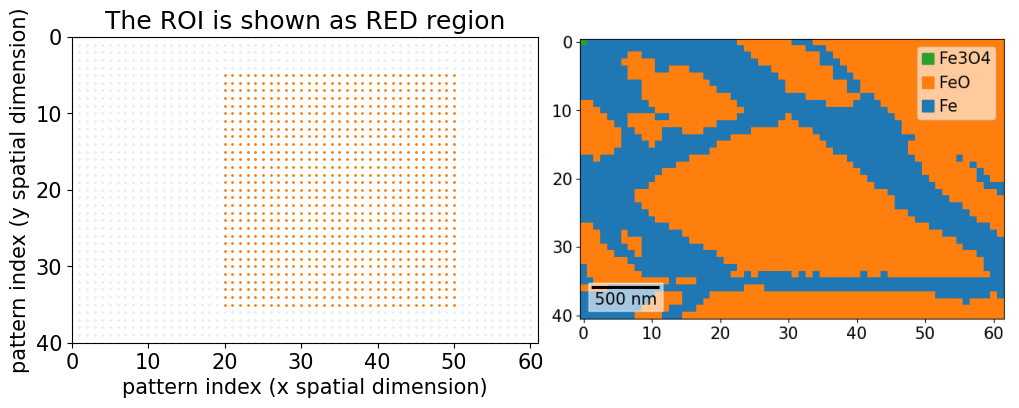

In [12]:
# set roi, get the serial number of ebsp in roi (for getting the phase index later)
R6, loc = set_ROI((20,50),(5,35), path, grid)

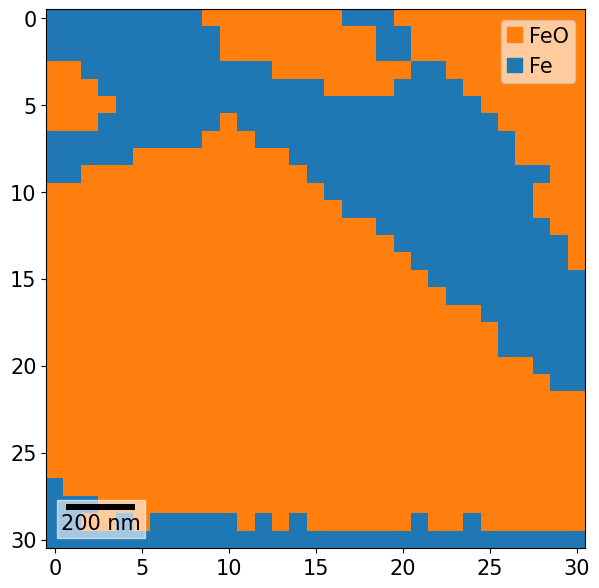

In [13]:
s_edax.inav[20:51,5:36].xmap.plot()

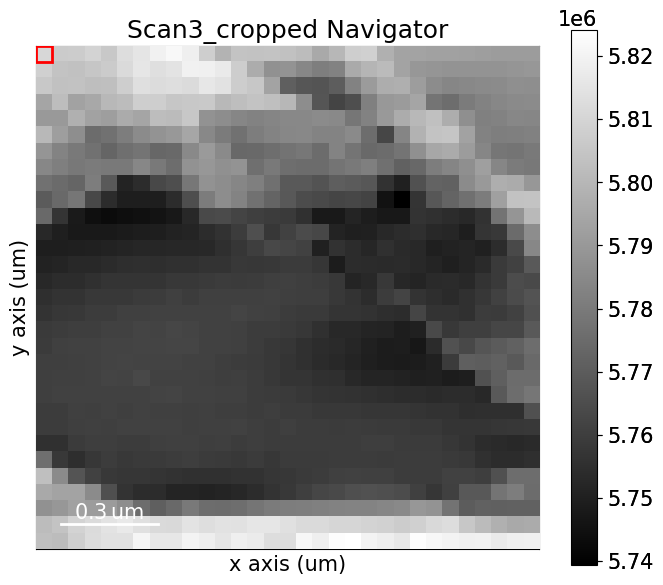

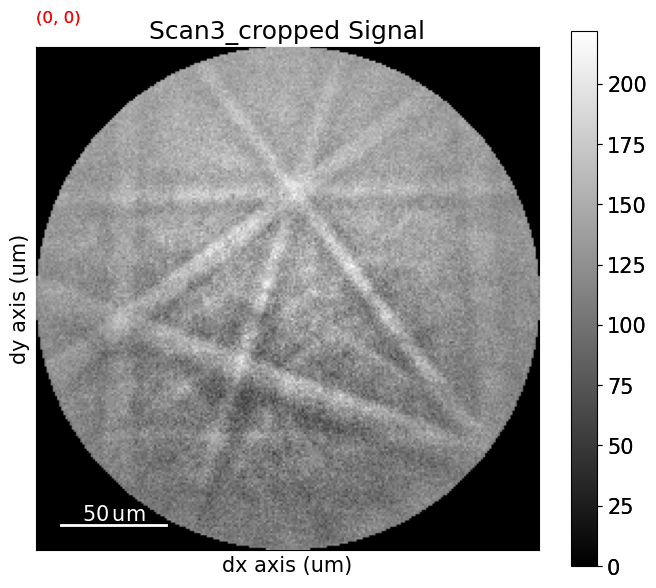

In [14]:
# ROI Image quality map
s_edax.inav[20:51,5:36].plot()

# s_edax.inav[40:42,27:29].plot()
# s_edax.inav[44:46,12:14].plot()

### 1.3 PCA

In [14]:
# dict {x,y} coordinates: phase index
coor_dict = coord_xmap_dict(s_edax.xmap,0.05)

In [15]:
# weights for each component
pca_scores = run_PCA(R6,2)

[########################################] | 100% Completed | 105.47 ms
[########################################] | 100% Completed | 107.42 ms
[########################################] | 100% Completed | 116.68 ms
[########################################] | 100% Completed | 111.77 ms
[########################################] | 100% Completed | 106.69 ms
[########################################] | 100% Completed | 106.61 ms
[########################################] | 100% Completed | 106.63 ms
[########################################] | 100% Completed | 105.39 ms
[########################################] | 100% Completed | 105.60 ms
[########################################] | 100% Completed | 105.74 ms
[########################################] | 100% Completed | 104.94 ms
[########################################] | 100% Completed | 105.27 ms
[########################################] | 100% Completed | 105.27 ms
[########################################] | 100% Completed | 10

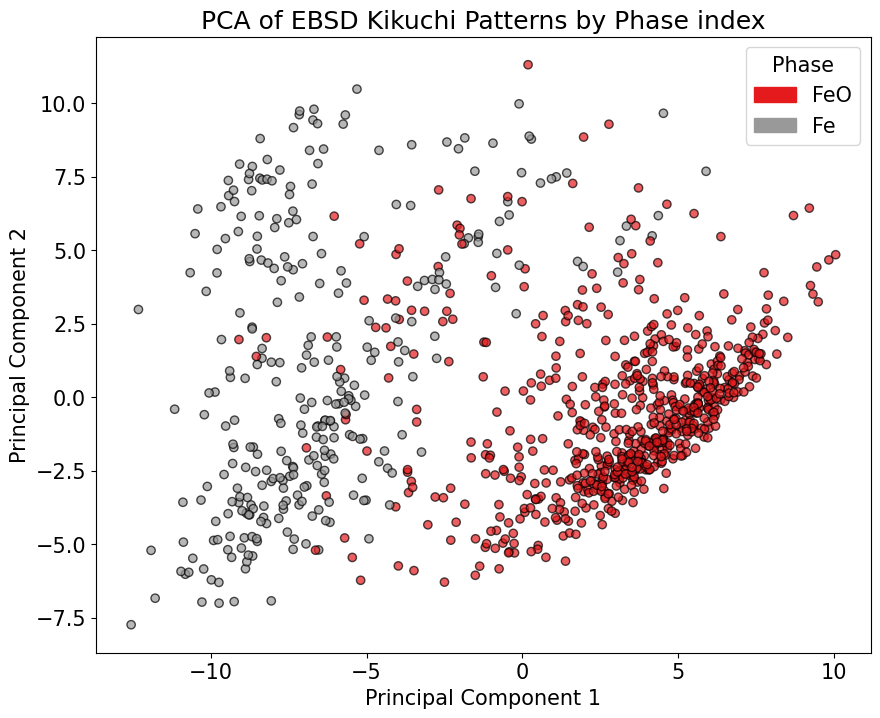

In [16]:
# plot pca weight for points within roi
_plot_pca(pca_scores, coor_dict, loc)

(961, 2)


(-0.5, 30.5, 30.5, -0.5)

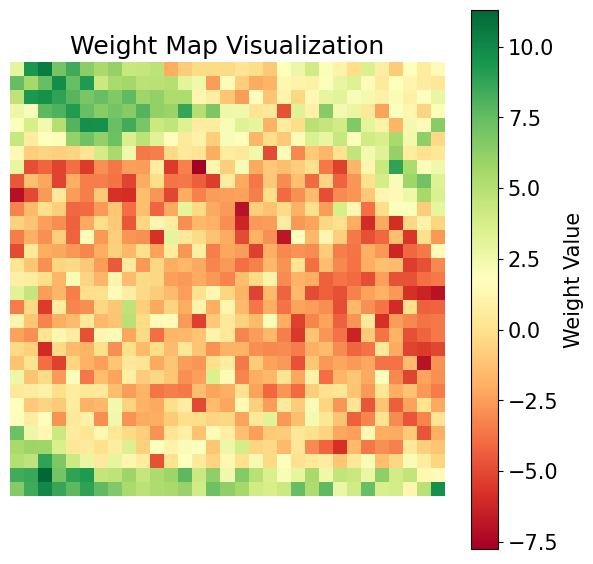

In [17]:
# visualize weight map of pca
print(np.shape(pca_scores))
weight_map = np.reshape(pca_scores, (31, 31, 2)) 
im= plt.imshow(np.transpose(weight_map[:, :, 1]), cmap="RdYlGn")
plt.colorbar(im, label='Weight Value') 
plt.title("Weight Map Visualization")
plt.axis('off')  

### 1.4 cNMF

In [17]:
components = get_components(
    R1, R2
)

The component C1 grid shape is (3, 3)
[                                        ] | 0% Completed | 917.60 us

[########################################] | 100% Completed | 117.37 ms
[########################################] | 100% Completed | 108.44 ms
The component C2 grid shape is (3, 3)
[########################################] | 100% Completed | 107.27 ms
[########################################] | 100% Completed | 107.96 ms


In [18]:
# run cNMF
weights,mse,r_square = run_cNMF(R6, components)

[########################################] | 100% Completed | 144.74 ms
[########################################] | 100% Completed | 104.14 ms
[########################################] | 100% Completed | 107.57 ms
[########################################] | 100% Completed | 106.38 ms
[########################################] | 100% Completed | 104.34 ms
[########################################] | 100% Completed | 106.44 ms
[########################################] | 100% Completed | 109.73 ms
[########################################] | 100% Completed | 106.24 ms
[########################################] | 100% Completed | 105.34 ms
[########################################] | 100% Completed | 105.03 ms
[########################################] | 100% Completed | 106.52 ms
[########################################] | 100% Completed | 104.60 ms
[########################################] | 100% Completed | 106.91 ms
[########################################] | 100% Completed | 10

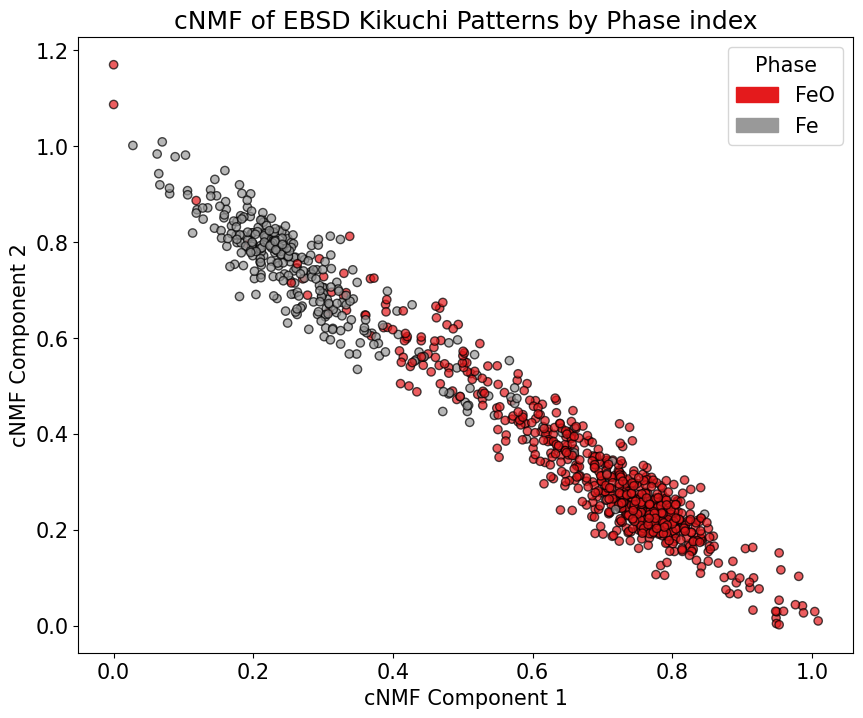

In [19]:
_plot_cnmf(weights, coor_dict, loc)

(961, 1, 2)


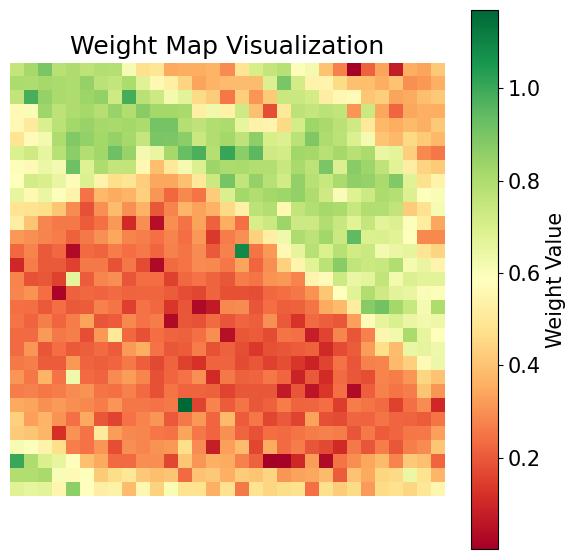

In [20]:
print(np.shape(weights))
weight_map = np.reshape(weights, (31, 31, 2)) 

im= plt.imshow(np.transpose(weight_map[:, :, 1]), cmap="RdYlGn")
plt.colorbar(im, label='Weight Value')  
plt.title("Weight Map Visualization")
plt.axis('off')  
plt.show()

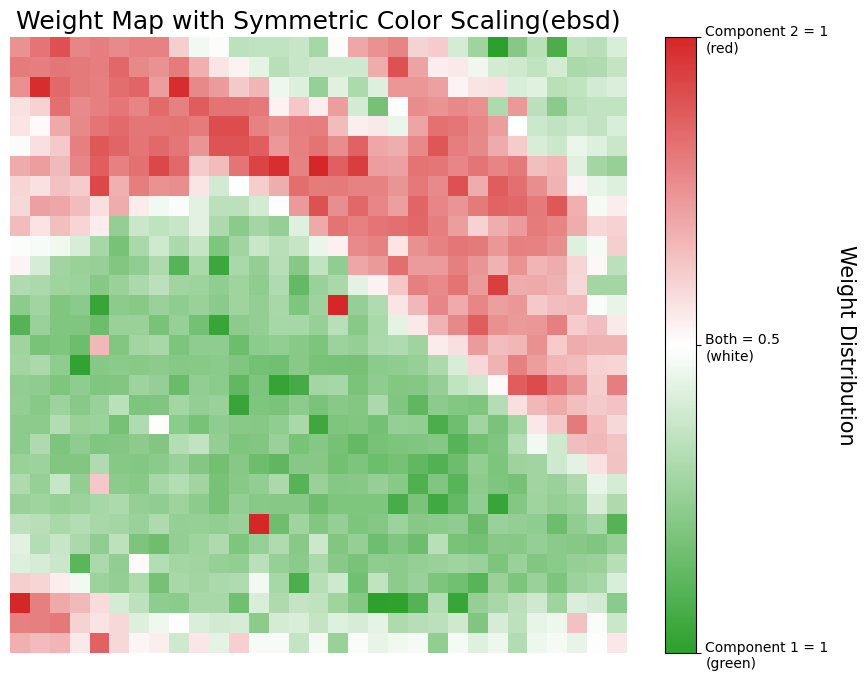

In [21]:
# Draw weight map for both components
data = np.transpose(weight_map[:, :, 1])
#Diverging Colormap
colors = ["#2ca02c", "#ffffff", "#d62728"]  # green-white-red
cmap_custom = LinearSegmentedColormap.from_list("custom_diverging", colors)

# mid point=0.5
norm = TwoSlopeNorm(vmin=0, vcenter=0.5, vmax=1)


plt.figure(figsize=(10, 8))
im = plt.imshow(data, cmap=cmap_custom, norm=norm)


cbar = plt.colorbar(im, ticks=[0, 0.5, 1])
cbar.ax.set_yticklabels([
    'Component 1 = 1\n(green)', 
    'Both = 0.5\n(white)', 
    'Component 2 = 1\n(red)'
], fontsize=10)
cbar.set_label('Weight Distribution', rotation=270, labelpad=20)


plt.title("Weight Map with Symmetric Color Scaling(ebsd)")
plt.axis('off')
plt.show()

### 1.3 EDS combined? （only content of elements）

### 1.3.1 cNMF

In [22]:
# stacked the pixel values with element values
eds_r1 = get_eds_average(x_range_1,y_range_1,s_edax)
eds_r2 = get_eds_average(x_range_2,y_range_2,s_edax)

eds_r1 = normalize_sum(eds_r1)
eds_r2 = normalize_sum(eds_r2)
eds = np.stack((eds_r1, eds_r2))

eds_mixed = np.hstack((components,eds))

In [23]:
weights,mse,r_square = run_cNMF_mixeds(R6, eds_mixed, loc, s_edax)

[                                        ] | 0% Completed | 1.16 ms

[########################################] | 100% Completed | 107.00 ms
[########################################] | 100% Completed | 145.37 ms
[########################################] | 100% Completed | 109.14 ms
[########################################] | 100% Completed | 104.97 ms
[########################################] | 100% Completed | 110.17 ms
[########################################] | 100% Completed | 149.04 ms
[########################################] | 100% Completed | 105.16 ms
[########################################] | 100% Completed | 104.79 ms
[########################################] | 100% Completed | 105.86 ms
[########################################] | 100% Completed | 104.46 ms
[########################################] | 100% Completed | 104.41 ms
[########################################] | 100% Completed | 104.45 ms
[########################################] | 100% Completed | 105.52 ms
[########################################] | 100% Completed | 10

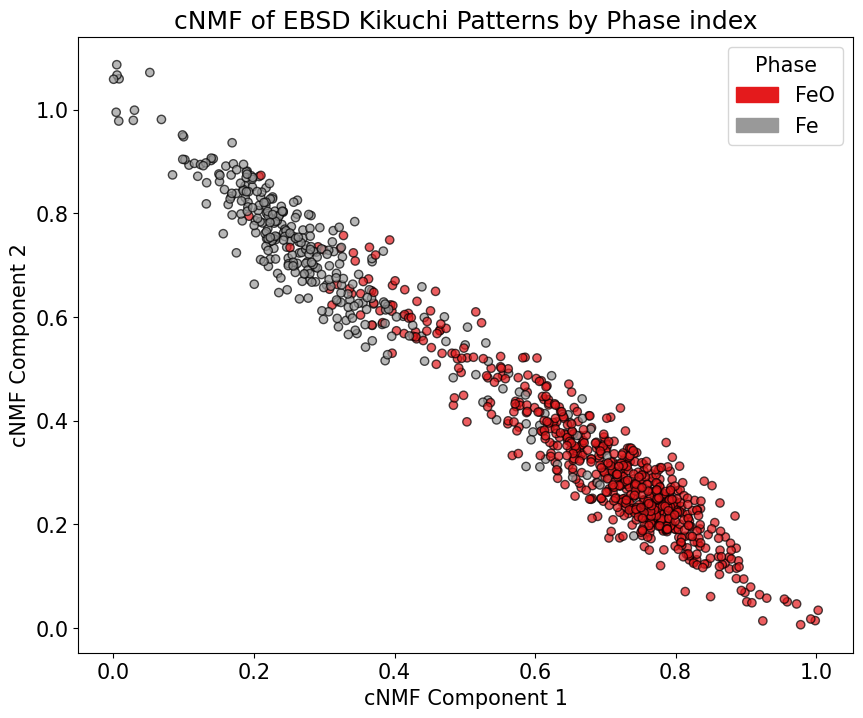

In [24]:
_plot_cnmf(weights, coor_dict, loc)

(961, 1, 2)


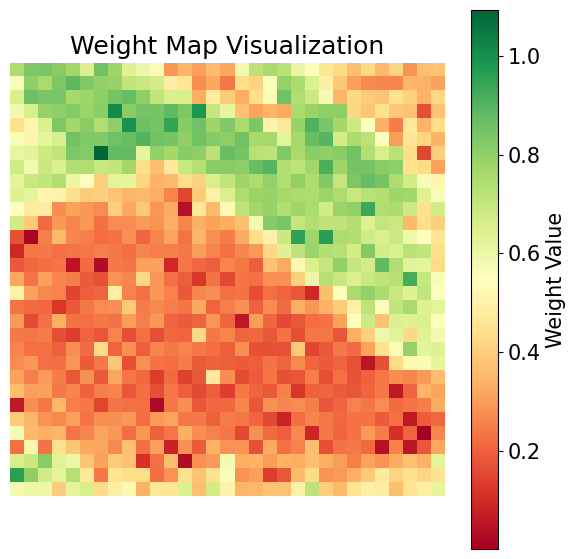

In [41]:
print(np.shape(weights))
weight_map = np.reshape(weights, (31, 31, 2)) 

im= plt.imshow(np.transpose(weight_map[:, :, 1]), cmap="RdYlGn")
plt.colorbar(im, label='Weight Value')  
plt.title("Weight Map Visualization")
plt.axis('off')  
plt.show()

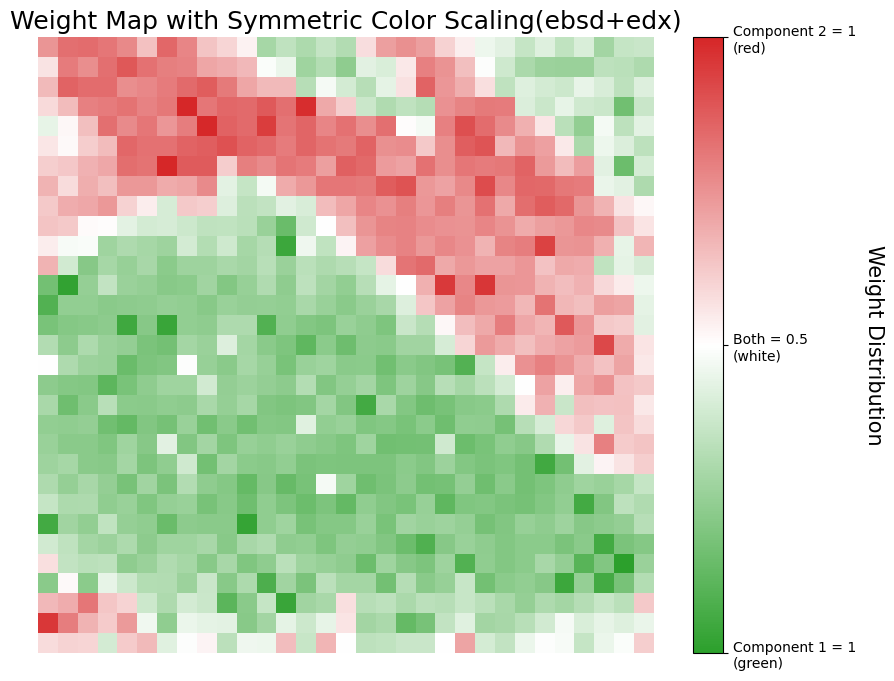

In [42]:
# Draw weight map for both components
data = np.transpose(weight_map[:, :, 1])
#Diverging Colormap
colors = ["#2ca02c", "#ffffff", "#d62728"]  # green-white-red
cmap_custom = LinearSegmentedColormap.from_list("custom_diverging", colors)

# mid point=0.5
norm = TwoSlopeNorm(vmin=0, vcenter=0.5, vmax=1)


plt.figure(figsize=(10, 8))
im = plt.imshow(data, cmap=cmap_custom, norm=norm)


cbar = plt.colorbar(im, ticks=[0, 0.5, 1])
cbar.ax.set_yticklabels([
    'Component 1 = 1\n(green)', 
    'Both = 0.5\n(white)', 
    'Component 2 = 1\n(red)'
], fontsize=10)
cbar.set_label('Weight Distribution', rotation=270, labelpad=20)


plt.title("Weight Map with Symmetric Color Scaling(ebsd+edx)")
plt.axis('off')
plt.show()